# 1. Data Exploration

In [1]:
#Importing Necessary Libraries
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn import metrics
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import seaborn as sns
from matplotlib.pylab import rcParams
import optuna
import xgboost as xgb
rcParams['figure.figsize'] = 12, 8

In [2]:
#Read files:
train = pd.read_csv(r"C:\Users\Manu\Documents\ineuron\Internship\Store_Sales_Prediction\data_given\Train.csv")
test = pd.read_csv(r"C:\Users\Manu\Documents\ineuron\Internship\Store_Sales_Prediction\data_given\Test.csv")

In [ ]:
train.dtypes

In [ ]:
test.dtypes

In [3]:
#Combine test and train into one file
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
print (train.shape, test.shape, data.shape)

(8523, 13) (5681, 12) (14204, 13)


In [4]:
#Converting column names to lowercase
data= data.rename(columns=str.lower)

In [ ]:
#Check missing values:
data.isnull().sum()

In [ ]:
profile = ProfileReport(data)
profile.to_widgets()

In [ ]:
#Number of unique values in each:
data.apply(lambda x: len(x.unique()))

In [5]:
#Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['item_identifier','outlet_identifier','source']]
#Print frequency of categories
for col in categorical_columns:
    print ('\nFrequency of Categories for varible %s'%col)
    print (data[col].value_counts())


Frequency of Categories for varible item_fat_content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: item_fat_content, dtype: int64

Frequency of Categories for varible item_type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: item_type, dtype: int64

Frequency of Categories for varible outlet_size
Medium    4655
Small     3980
High      1553
Name: outlet_size, dtype: int64

Frequency of Categories for varible outlet_location_type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: outlet_location_type, dtype: int64

F

# 2. Feature Engineering:

### Modify Item_Visibility

In [6]:
#Checking number of 0s in Item_Visibility
miss_bool = (data['item_visibility'] == 0)
print ('Number of 0 values initially: %d'%sum(miss_bool))

NumExpr defaulting to 4 threads.


Number of 0 values initially: 879


In [8]:
data["item_visibility"][data['item_visibility'] == 0] = np.nan
miss_bool = (data['item_visibility'] == 0)
print ('Number of 0 values now: %d'%sum(miss_bool))

Number of 0 values now: 0


<ipython-input-8-7ccaca10c74e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["item_visibility"][data['item_visibility'] == 0] = np.nan


### Create a broad category of Type of Item

In [9]:
#Item type combine:
data['item_identifier'].value_counts()
data['item_type_combined'] = data['item_identifier'].apply(lambda x: x[0:2])
data['item_type_combined'] = data['item_type_combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['item_type_combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: item_type_combined, dtype: int64

### Determine the years of operation of a store

In [10]:
from datetime import date
#Years:
data['outlet_years'] = date.today().year - data['outlet_establishment_year']
data['outlet_years'].describe()

count    14204.000000
mean        24.169319
std          8.371664
min         13.000000
25%         18.000000
50%         23.000000
75%         35.000000
max         37.000000
Name: outlet_years, dtype: float64

### Modify categories of Item_Fat_Content

In [12]:
#Change categories of low fat:
print ('Original Categories:')
print (data['item_fat_content'].value_counts())

print ('\nModified Categories:')
data['item_fat_content'] = data['item_fat_content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print (data['item_fat_content'].value_counts())

Original Categories:
Low Fat    9185
Regular    5019
Name: item_fat_content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: item_fat_content, dtype: int64


In [13]:
#Mark non-consumables as separate category in low_fat:
data.loc[data['item_type_combined']=="Non-Consumable",'item_fat_content'] = "Non-Edible"
data['item_fat_content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: item_fat_content, dtype: int64

In [ ]:
data.head()

### Imputation

In [14]:
#Label Encoding to impute missing values For regression, SVC, etc.
le = LabelEncoder()
#encoders=dict()
series = data['outlet_size']
data['outlet_size'] = pd.Series(le.fit_transform(series[series.notnull()]), index=series[series.notnull()].index)
#encoders['Outlet_Size'] = le

In [15]:
#Check the mean sales by type:
data.pivot_table(values='item_outlet_sales',index='outlet_type')

,item_outlet_sales
outlet_type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


In [ ]:
data.dtypes

In [16]:
convert_dict = {'outlet_establishment_year': float,
                'outlet_years': float}
data = data.astype(convert_dict)

In [17]:
# Using Knn imputer to impute missing values instead of using mean, mode, median, etc.
imputer = KNNImputer()
data.loc[:,(data.dtypes=='float64').values] = imputer.fit_transform(data.loc[:,(data.dtypes=='float64').values])

In [18]:
#Rounding off the imputed values
data['outlet_size'] = np.round(data['outlet_size'])

In [19]:
#Inverse transforming the encoded values
data['outlet_size'] = le.inverse_transform(data['outlet_size'].astype(int))

### Dropping unnecessary columns

In [20]:
#Drop the columns which have been converted to different types:
data.drop(['item_type','outlet_establishment_year'],axis=1,inplace=True)

### Creating Schema

In [21]:
overview = data.loc[:, data.columns != 'item_outlet_sales'].describe()

In [22]:
overview.loc[["min", "max"]].to_json("schema_in.json")

### Dummy Variables Creation

In [23]:
data = pd.get_dummies(data, columns=['item_fat_content','outlet_location_type','outlet_size','outlet_type',
                              'item_type_combined'])

### Checking for multicollinearity

In [ ]:
#Calculating VIF score for treating multicollinearity
def vif_score(x):
    temp =x
    scaler = StandardScaler()
    arr = scaler.fit_transform(temp)
    return pd.DataFrame([[temp.columns[i], variance_inflation_factor(arr,i)] for i in range(arr.shape[1])], columns=["FEATURE", "VIF_SCORE"])

In [ ]:
vif_score(data.loc[:,(data.dtypes=='float64').values])

### Exporting Data

In [24]:
#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['item_outlet_sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
#train.to_csv("train_modified.csv",index=False)
#test.to_csv("test_modified.csv",index=False)

C:\Users\Manu\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
train['Item_Identifier'].dtypes

# Function to model fit:

In [ ]:
sorted(metrics.SCORERS.keys())

In [25]:
#Define target and ID columns:
target = 'item_outlet_sales'
IDcol = ['item_identifier','outlet_identifier']
from sklearn.model_selection import cross_val_score
def modelfit(alg, dtrain, dtest, predictors, target, IDcol):
        
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\nModel Report")
    print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #return model
    #Export submission file:
    #IDcol.append(target)
    #submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    #submission.to_csv(filename, index=False)

### Normalizing data for certain algorithms

In [ ]:
scaler = StandardScaler()

predictors = [x for x in train.columns if x not in [target]+IDcol]

#Normalizing train data
arr_train = scaler.fit_transform(train[predictors].values)
train_scaled = pd.DataFrame(arr_train, index=train[predictors].index, columns=train[predictors].columns)
train_scaled['item_identifier'] = train['item_identifier']
train_scaled['outlet_identifier'] = train['outlet_identifier']
train_scaled[target] = train[target]

#Normalizing test data
arr_test = scaler.fit_transform(test[predictors].values)
test_scaled = pd.DataFrame(arr_test, index=test[predictors].index, columns=test[predictors].columns)
test_scaled['item_identifier'] = test['item_identifier']
test_scaled['outlet_identifier'] = test['outlet_identifier']

# Model Building

### Linear Regression

In [ ]:
predictors = [x for x in train_scaled.columns if x not in [target]+IDcol]

# print predictors
alg1 = LinearRegression()

modelfit(alg1, train_scaled, test_scaled, predictors, target, IDcol)
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

### Ridge Regression

In [ ]:
predictors = [x for x in train_scaled.columns if x not in [target]+IDcol]
alg2 = Ridge(alpha=0.05)
modelfit(alg2, train_scaled, test_scaled, predictors, target, IDcol)
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')

### Decision Tree Regression


Model Report
RMSE : 1059
CV Score : Mean - 1091 | Std - 44.34 | Min - 1004 | Max - 1180


<ipython-input-25-9469bcc47457>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtest[target] = alg.predict(dtest[predictors])


<AxesSubplot:title={'center':'Feature Importances'}>

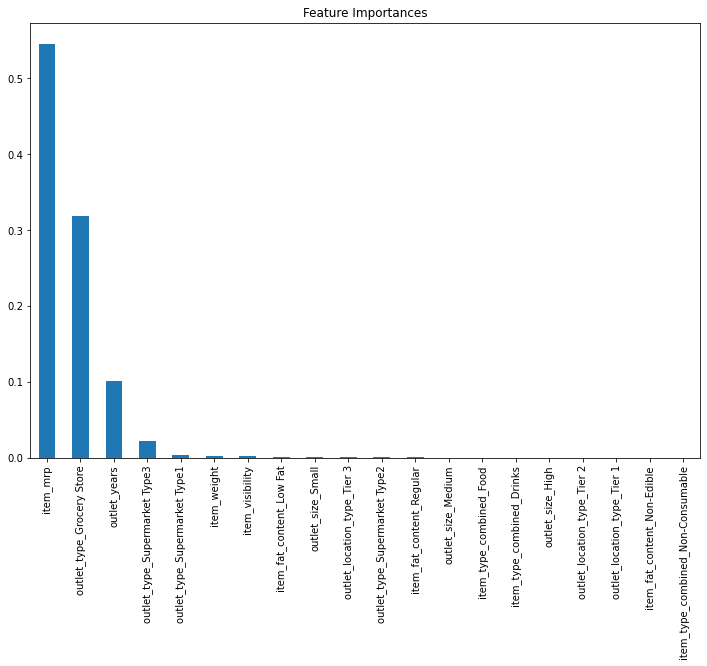

In [26]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg3, train, test, predictors, target, IDcol)
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')

In [ ]:
predictors = ['Item_MRP','Outlet_Type_Grocery Store','Outlet_Type_Supermarket Type3','Outlet_Years']
alg4 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
modelfit(alg4, train, test, predictors, target, IDcol)
coef4 = pd.Series(alg4.feature_importances_, predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')

In [ ]:
cols

In [ ]:
test.head()

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg5, train, test, predictors, target, IDcol)
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')

In [ ]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg6 = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)
modelfit(alg6, train, test, predictors, target, IDcol)
coef6 = pd.Series(alg6.feature_importances_, predictors).sort_values(ascending=False)
coef6.plot(kind='bar', title='Feature Importances')

In [27]:
import joblib
joblib.dump(alg3, open(r'C:\Users\Manu\Documents\ineuron\Internship\Store_Sales_Prediction\prediction_service\model\model.joblib' , 'wb'))